In [3]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

from collections import defaultdict
from collections import Counter

from time import time

import pandas as pd
import numpy as np

import src.utilities as ut

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, confusion_matrix

# Import data set:

In [4]:
pd.options.mode.chained_assignment = None


df_full = ut.import_dataset(encoding='utf-8')
df_full.head()

,text,class
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",Ανθρωποκτονία
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",Ανθρωποκτονία
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",Ανθρωποκτονία
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",Ανθρωποκτονία
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",Ανθρωποκτονία


Kept only the column of interest leaving out the column with `class` labels.

In [5]:
df = df_full[['text']]
df['text'] = df['text'].astype('string')

df.head()

,text
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ..."
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ..."
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π..."
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα..."
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι..."


# Exploratory Data Analysis:

Let's do a little bit of EDA of these texts.

## Length of texts:

In [6]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,517.0,2584.237911,2233.321715,144.0,1336.0,1902.0,3066.0,20566.0


Visualize the results above using a boxplot:

<AxesSubplot:>

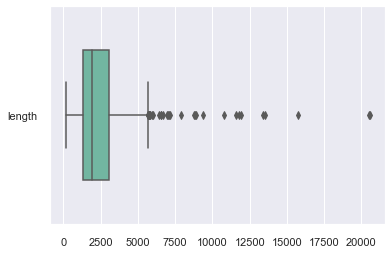

In [7]:
# Box plot:
sns.set_theme(style="darkgrid")
sns.boxplot(data=df, orient='h', width=.6, palette="Set2")

When the median is closer to the bottom of the box and the whisker is shorter on the lower end of the box, the distribution is right-skewed (or “positively” skewed). This probably means that the classifier we are trying to built here will be better at predicting the class of the given text, for texts that are of relatively small length.

We can try to apply some kind of transformation in order to deal with skewness. This step eould crucial if the length of texts could play an important role in classifying them.

Below a `log transformation` is use in order to create a more *gaussian-like* distribution.

In [10]:
df['log_length'] = np.log(df['length'])

After this we create a new boxplot in order to visualize the data once again.

<AxesSubplot:>

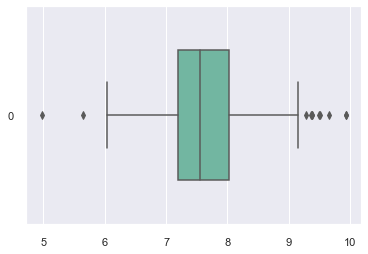

In [11]:
sns.boxplot(data=df['log_length'], orient='h', width=.6, palette="Set2")

# Text processing:

Now we will create a **pipeline** in order to process the textual data we have. The **pipeline** will consist of the following steps:

- Lowercase all characters
- Drop numbers
- Remove punctuation
- Remove stopwords. The list of stopwords can be found here.
- Single letter words are dropped, too.
- Tokenization
- Lemmatization. The process during which all words are turned into their roots.

Of course, the above **pipeline** can be adjusted by moving or adding other steps depending on the use case.